In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
# setup disply parameters
import pandas as pd
import numpy as np
from matplotlib import pylab as plt
from matplotlib.ticker import StrMethodFormatter
float_formatter = StrMethodFormatter('{x:0.03f}')
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('figure', figsize=(18, 6)) # set figure size

In [2]:
from abc import abstractmethod, ABC
from dataclasses import dataclass, field
from random import random
from negmas import Mechanism, MechanismRoundResult, Negotiator, AspirationMixin
from negmas import MechanismState
from negmas import AgentMechanismInterface
from negmas import outcome_as_tuple
from typing import Callable, Tuple, Optional, List, Any, Dict
from negmas import Outcome, Issue, UtilityFunction, LinearUtilityFunction, ExpDiscountedUFun,ResponseType
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import seaborn as sns
import nashpy
from negmas import outcomes as O

In [3]:
class PriceVolumeUtilityServer(UtilityFunction): #Vendedor
    
    def __init__(self,price):
        super().__init__()
        self.min_price = price[0]
        self.max_price = price[-1]
 
    def __call__(self, offer):
        return ((offer - self.min_price)/(self.max_price - self.min_price))    
    
    def xml(self):
        pass

In [4]:
class PriceVolumeUtilityClient(UtilityFunction): #Comprador
    
    def __init__(self,price):
        super().__init__()
        self.min_price = price[0]
        self.max_price = price[-1]
    
    def __call__(self, offer):
        return (1 - (offer - self.min_price)/(self.max_price - self.min_price))
    
    def xml(self):
        pass

In [5]:
from negmas import outcomes as O
from typing import Any, Dict, List, Optional, Tuple, Union
import random

class RubinsteinMechanism(Mechanism):
  
    def __init__(self,show = False,**kwargs):
        kwargs.update(dict(max_n_agents=2, dynamic_entry=False))
        super().__init__(**kwargs)
        self.add_requirements(dict(propose_for_self = True))
        self.ufuns: List[UtilityFunction] = []
        self.last_offer = 0
        self.offer_history = []
        self.show = show
        self.first = random.randint(0,1)
        self.second = 1 if self.first==0 else 0

    def add(self,negotiator: "Negotiator",*,ufun: Optional["UtilityFunction"] = None,**kwargs,) -> Optional[bool]:
        added = super().add(negotiator, ufun=ufun, role=None, **kwargs)
        if added:
            self.ufuns.append(self.negotiators[-1].utility_function)
            
    def round(self)-> MechanismRoundResult:
        """One round of the mechanism"""
        
        if self.current_step == 0:
            if len(self.negotiators) != 2:
                return MechanismRoundResult(error=True,
                                        error_details=f"Got {len(self.negotiators)} negotiators!!",
                                        broken=True)

            
                
            self.last_offer = self.negotiators[self.first].propose_for_self(self.ufuns,0,self.current_step)
            self.offer_history.append([self.negotiators[self.first].name,self.current_step,self.last_offer])
            if self.show:
                print('Time {}: Agent {} offers Agent {}: {}'.format(self.current_step,self.negotiators[self.first].name,self.negotiators[self.second].name,self.last_offer))
        
        else:
            #outcomes = list(n.propose_for_self(self.ufuns,self.current_step+1) for n in self.negotiators)
            '''if any(o is None for o in outcomes):
            return MechanismRoundResult(broken=True)'''

            if (self.current_step) % 2 != 0: #Turno para Agente2 

                '''if not self.is_feasible(outcomes[0]):
                    return MechanismRoundResult(broken=True)'''

                #Turno para Agente2 para aceptar la oferta,rechazarla o contraofertas
                if self.show:
                    print('Time {}: Agent {} is evaluating offer'.format(self.current_step,self.negotiators[self.second].name))
                evaluation = self.negotiators[self.second].evaluate(self.ufuns,self.last_offer,self.current_step)
                if  evaluation == 1:
                    if self.show:
                        print('Time {}: and Agent {} accepts offer: {}'.format(self.current_step,self.negotiators[self.second].name,self.last_offer))
                    return MechanismRoundResult(agreement = self.last_offer) #Aceptar oferta
                elif evaluation == 0:
                    if self.show:
                        print('Time {}: and Agent {} rejects offer: {}'.format(self.current_step,self.negotiators[self.second].name,self.last_offer))
                    return MechanismRoundResult(broken=True) #Rechazar
                else:
                    if self.show:
                        print('Time {}: and Agent {} counteroffers: {}'.format(self.current_step,self.negotiators[self.second].name,evaluation))
                    self.last_offer = evaluation
                    self.offer_history.append([self.negotiators[self.second].name,self.current_step,self.last_offer])


            else:#Turno para Agente1

                '''if not self.is_feasible(outcomes[0]):
                    return MechanismRoundResult(broken=True)'''
                if self.show:
                    print('Time {}: Agent {} is evaluating offer:'.format(self.current_step,self.negotiators[self.first].name))
                evaluation = self.negotiators[self.first].evaluate(self.ufuns,self.last_offer,self.current_step)
                if  evaluation == 1:
                    if self.show:
                        print('Time {}: and Agent {} accepts offer: {}'.format(self.current_step,self.negotiators[self.first].name,self.last_offer))
                    return MechanismRoundResult(agreement = self.last_offer) #Aceptar oferta
                elif evaluation == 0:
                    if self.show:
                        print('Time {}: and Agent {} rejects offer: {}'.format(self.current_step,self.negotiators[self.first].name,self.last_offer))
                    return MechanismRoundResult(broken=True) #Rechazar
                else:
                    if self.show:
                        print('Time {}: and Agent {} counteroffers: {}'.format(self.current_step,self.negotiators[self.first].name,evaluation))
                    self.last_offer = evaluation
                    self.offer_history.append([self.negotiators[self.first].name,self.current_step,self.last_offer])

        
        return MechanismRoundResult()
    
    def print_history(self):
        for i in self.offer_history:
            print(i)
    
    def plot(self, visible_negotiators: Union[Tuple[int, int], Tuple[str, str]] = (0, 1), plot_utils=True, plot_outcomes=False,utility_range: Optional[Tuple[float, float]] = None):
        
        import matplotlib.pyplot as plt
            
        history = []
        for of in self.offer_history:
            history.append(
                {
                    "current_proposer": of[0],
                    "current_offer": of[2],
                    "step": of[1],
                    "u0": self.negotiators[0].utility_function(of[2]),
                    "u1": self.negotiators[1].utility_function(of[2]),
                }
            )
            
        offers = []
        steps = []
        u1 = []
        u2 = []
        
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
        
        ax1.set_title('History of offers')
        
        for h in history:
            offers.append(h["current_offer"])
            steps.append(h["step"])
            u1.append(h["u0"])
            u2.append(h["u1"])
    
        ax1.plot(steps,offers)
        ax1.plot(steps,offers,'ro',label='Offers')
        ax1.set_ylabel('Price')
        ax1.set_xlabel('Time')
        if self.state.agreement is not None:
            agreement = history[-1]
            ax1.plot(agreement["step"],agreement["current_offer"],'ro',label='Agreement',color='g') 
        ax1.legend()
        
        ax2.set_title("History of utilities")

        ax2.plot(steps,u1,label='Utility for Server')
        ax2.plot(steps,u2,label='Utility for Client')
        ax2.set_xlabel('Time')
        ax2.legend()
        
        ax3.set_title('Utilities')
        ax3.plot(u1,u2)
        ax3.set_xlabel('Utility for Server')
        ax3.set_ylabel('Utility for Client')
        
        ax3.plot(u1,u2,'r^',label='Offers')
        
        if self.state.agreement is not None:
            agreement = history[-1]
            ax3.plot(agreement["u0"],agreement["u1"],'ro',label='Agreement',color='g') 
        
        ax3.legend()

In [6]:
class FaratinNegotiator(Negotiator):

    def __init__(self, index, max_time, mins, maxs, Beta, k, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.add_capabilities(dict(propose_for_self=True))
        self.index = index
        self.other = 1 if self.index==0 else 0
        self.last_score = np.inf
        self.last_offer = []
        self.max_time = max_time
        self.min_values = mins
        self.max_values = maxs
        self.Beta = Beta
        self.k = k

        
    def evaluate(self, ufuns: List[UtilityFunction],offer,time: int):
        if ufuns[self.index](offer) >= self.last_score:
            return 1 #Accept offer
        elif time >= self.max_time:
            return 0 #Reject offer
        else:
            self.last_score = ufuns[self.index](offer)
            self.last_offer.append(offer)
            counteroffer = self.propose_for_self(ufuns,offer,time)
            self.last_score = ufuns[self.index](counteroffer)
            self.last_offer.append(counteroffer)
            if counteroffer == offer or ufuns[self.index](counteroffer)<ufuns[self.index](offer):
                return 1
            return counteroffer #Counter offer
                 
    @abstractmethod    
    def propose_for_self(self, ufuns: List[UtilityFunction],offer, time: int) -> List[int]:
        return

# TIME DEPENDENT TACTICS

In [7]:
class FaratinNegotiatorTimeServer(FaratinNegotiator):
    
    def propose_for_self(self, ufuns: List[UtilityFunction], offer, time: int) -> int:
        return int(self.min_values + (1-self.alpha_function(time))*(self.max_values - self.min_values))
    
    def alpha_function(self,time):
        if time==0:
            return self.k
        return self.k + (1-self.k)*pow(min(time,self.max_time)/self.max_time,(1/self.Beta))



In [8]:
class FaratinNegotiatorTimeClient(FaratinNegotiator):
    
    def propose_for_self(self, ufuns: List[UtilityFunction], offer, time: int) -> int:
        return int(self.min_values + self.alpha_function(time)*(self.max_values - self.min_values))
        
    def alpha_function(self,time):
        if time==0:
            return self.k
        return self.k + (1-self.k)*pow(min(time,self.max_time)/self.max_time,(1/self.Beta))


Time 0: Agent Server offers Agent Client: 28
Time 1: Agent Client is evaluating offer
Time 1: and Agent Client counteroffers: 3
Time 2: Agent Server is evaluating offer:
Time 2: and Agent Server counteroffers: 24
Time 3: Agent Client is evaluating offer
Time 3: and Agent Client counteroffers: 7
Time 4: Agent Server is evaluating offer:
Time 4: and Agent Server counteroffers: 20
Time 5: Agent Client is evaluating offer
Time 5: and Agent Client counteroffers: 11
Time 6: Agent Server is evaluating offer:
Time 6: and Agent Server counteroffers: 17
Time 7: Agent Client is evaluating offer
Time 7: and Agent Client counteroffers: 14
Time 8: Agent Server is evaluating offer:
Time 8: and Agent Server accepts offer: 14
Agreed to: 14 in 9 steps


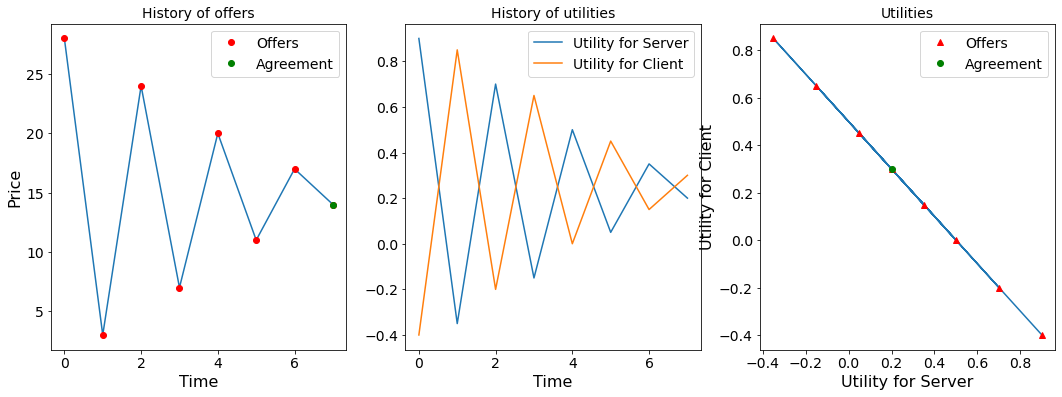

In [49]:
U1 = PriceVolumeUtilityServer([10,30]) 
U2 = PriceVolumeUtilityClient([0,20]) 

A1 = FaratinNegotiatorTimeServer(0,max_time=10, mins=10, maxs=30, Beta = 1, k= 0.1, ufun=U1, name="Server")
A2 = FaratinNegotiatorTimeClient(1,max_time=10, mins=0, maxs=20, Beta = 1, k= 0.1, ufun=U2, name="Client" )


m = RubinsteinMechanism(show=True)

m.add(A1)
m.add(A2)


result = m.run()
print(f"Agreed to: {result.agreement} in {m.current_step} steps")

m.plot()

# RESOURCE DEPENDENT TACTICS

In [10]:
import random as rnd
import math

In [11]:
Resource = []
def resource_consumed(t):
    r = max(1-t*0.1,0)
    Resource.append(r)
    return r

def plot_resource(t):
    plt.figure(figsize=(7,7))
    plt.plot(range(t-1),Resource, color='salmon')
    plt.xlabel('Time')
    plt.ylabel('Resource')
    plt.fill_between(range(t-1), Resource, color='salmon')

In [12]:
class FaratinNegotiatorResourceServer(FaratinNegotiator):
    
    def propose_for_self(self, ufuns: List[UtilityFunction],offer, time: int)-> int:
        return int(self.min_values + (1-self.alpha_function(time))*(self.max_values - self.min_values))

    def alpha_function(self,time):
        if time==0:
            return self.k
        return self.k + (1-self.k)*math.exp(-resource_consumed(time))
    


In [13]:
class FaratinNegotiatorResourceClient(FaratinNegotiator):
    
    def propose_for_self(self, ufuns: List[UtilityFunction],offer, time: int)-> int:
        return int(self.min_values + self.alpha_function(time)*(self.max_values - self.min_values))
        
    def alpha_function(self,time):
        if time==0 :
            return self.k
        return self.k + (1-self.k)*math.exp(-resource_consumed(time))

Time 0: Agent Client offers Agent Server: 2
Time 1: Agent Server is evaluating offer
Time 1: and Agent Server counteroffers: 20
Time 2: Agent Client is evaluating offer:
Time 2: and Agent Client counteroffers: 10
Time 3: Agent Server is evaluating offer
Time 3: and Agent Server counteroffers: 19
Time 4: Agent Client is evaluating offer:
Time 4: and Agent Client counteroffers: 11
Time 5: Agent Server is evaluating offer
Time 5: and Agent Server counteroffers: 17
Time 6: Agent Client is evaluating offer:
Time 6: and Agent Client counteroffers: 14
Time 7: Agent Server is evaluating offer
Time 7: and Agent Server accepts offer: 14
Agreed to: 14 in 8 steps


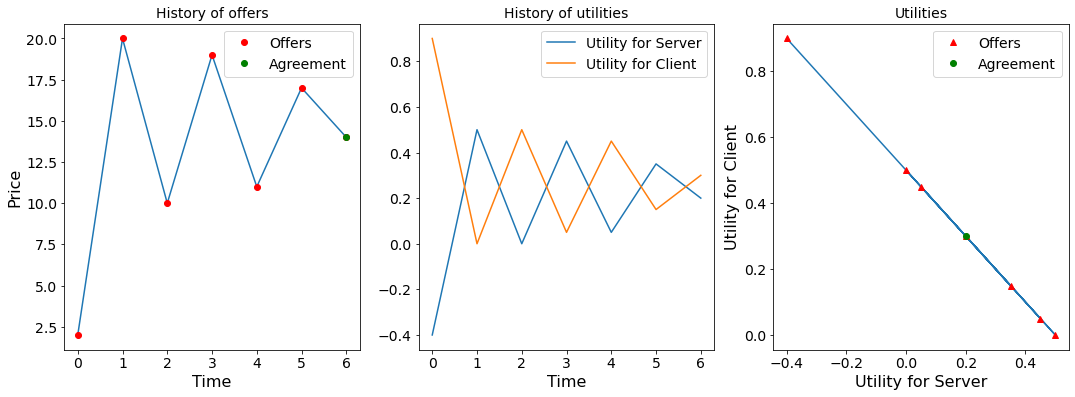

In [14]:
U1 = PriceVolumeUtilityServer([10,30]) 
U2 = PriceVolumeUtilityClient([0,20]) 

A1 = FaratinNegotiatorResourceServer(0,max_time=10, mins=10, maxs=30, Beta = 1, k= 0.1, ufun=U1, name="Server")
A2 = FaratinNegotiatorResourceClient(1,max_time=10, mins=0, maxs=20, Beta = 1, k= 0.1, ufun=U2, name="Client" )

m = RubinsteinMechanism(show=True)

m.add(A1)
m.add(A2)


result = m.run()
print(f"Agreed to: {result.agreement} in {m.current_step} steps")

m.plot()


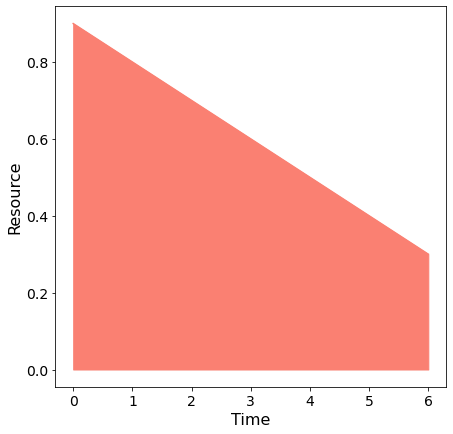

In [15]:
plot_resource(m.current_step)

# BEHAVIOUR DEPENDENT TACTICS

In [16]:
class FaratinNegotiator_Relative_Tit_For_Tat_Server(FaratinNegotiator):
    
    def __init__(self, index, max_time, mins, maxs, Delta, k,  *args, **kwargs):
        super().__init__(index, max_time, mins, maxs, None, k,*args, **kwargs)
        self.delta = Delta
        self.initial =  int(self.min_values + (1-self.k)*(self.max_values - self.min_values))
    
    def propose_for_self(self, ufuns: List[UtilityFunction],offer, time: int)-> float:
        if  time == 0 :
            self.last_score = ufuns[self.index](self.initial)
            self.last_offer.append(self.initial)
            return self.initial
        if time == 1:
            return self.initial
        if time<=2*self.delta:
            return round(self.initial - (self.k)*(self.max_values - self.min_values))
        else:
            x = min(max((self.last_offer[(time-1)-2*self.delta]/self.last_offer[(time-1)-2*self.delta+2])*self.last_offer[-2],self.min_values),self.max_values) 
            return round(x)

In [17]:
class FaratinNegotiator_Relative_Tit_For_Tat_Client(FaratinNegotiator):
    
    def __init__(self, index, max_time, mins, maxs, Delta, k,  *args, **kwargs):
        super().__init__(index, max_time, mins, maxs, None, k,*args, **kwargs)
        self.delta = Delta
        self.initial =  int(self.min_values + (self.k)*(self.max_values - self.min_values))
    
    def propose_for_self(self, ufuns: List[UtilityFunction], offer, time: int)-> float:
        if  time == 0 :
            self.last_score = ufuns[self.index](self.initial)
            self.last_offer.append(self.initial)
            return self.initial
        if time == 1:
            return self.initial
        if time<=2*self.delta:
            return round(self.initial + (self.k)*(self.max_values - self.min_values))
        else:
            x = min(max((self.last_offer[(time-1)-2*self.delta]/self.last_offer[(time-1)-2*self.delta+2])*self.last_offer[-2],self.min_values),self.max_values) 
            return round(x)

Time 0: Agent Client offers Agent Server: 12
Time 1: Agent Server is evaluating offer
Time 1: and Agent Server counteroffers: 28
Time 2: Agent Client is evaluating offer:
Time 2: and Agent Client counteroffers: 14
Time 3: Agent Server is evaluating offer
Time 3: and Agent Server counteroffers: 24
Time 4: Agent Client is evaluating offer:
Time 4: and Agent Client counteroffers: 16
Time 5: Agent Server is evaluating offer
Time 5: and Agent Server counteroffers: 21
Time 6: Agent Client is evaluating offer:
Time 6: and Agent Client counteroffers: 18
Time 7: Agent Server is evaluating offer
Time 7: and Agent Server counteroffers: 19
Time 8: Agent Client is evaluating offer:
Time 8: and Agent Client accepts offer: 19
Agreed to: 19 in 9 steps


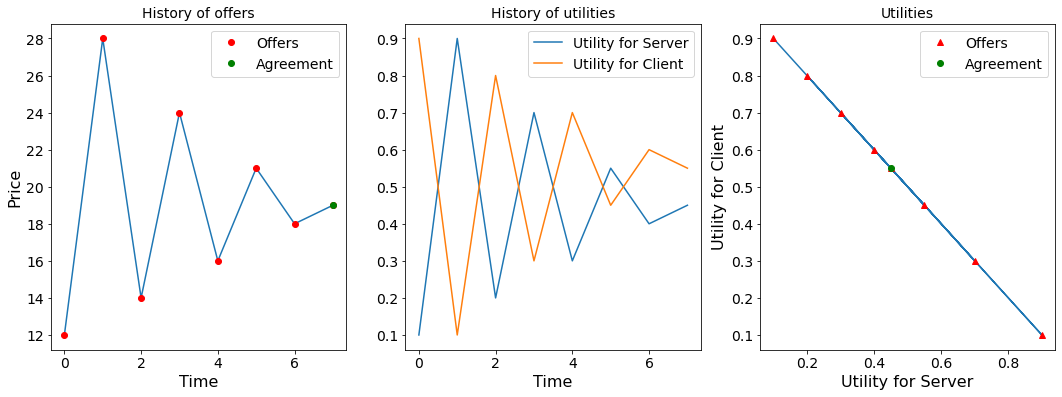

In [18]:
U1 = PriceVolumeUtilityServer([10,30]) 
U2 = PriceVolumeUtilityClient([10,30])

A1 = FaratinNegotiator_Relative_Tit_For_Tat_Server(0,max_time=15, mins=10, maxs=30, Delta = 1, k=0.1, ufun=U1, name="Server")
A2 = FaratinNegotiator_Relative_Tit_For_Tat_Client(1,max_time=15, mins=10, maxs=30, Delta = 1, k=0.1, ufun=U2, name="Client" )

m = RubinsteinMechanism(show=True)

m.add(A1)
m.add(A2)


result = m.run()
print(f"Agreed to: {result.agreement} in {m.current_step} steps")

m.plot()

In [19]:
class FaratinNegotiator_AverageAbsoluteTitForTat_Server(FaratinNegotiator):
    
    def __init__(self, index, max_time, mins, maxs, Delta, k,*args, **kwargs):
        super().__init__(index, max_time, mins, maxs, None, k,*args, **kwargs)
        self.delta = Delta
        self.initial = int(self.min_values + (1-self.k)*(self.max_values - self.min_values))
    
    def propose_for_self(self, ufuns: List[UtilityFunction],offer, time: int)-> int:
        if  time == 0 :
            self.last_score = ufuns[self.index](self.initial)
            self.last_offer.append(self.initial)
            return self.initial
        if time == 1:
            return self.initial
        if time<=2*self.delta:
            return round(self.initial - (self.k)*(self.max_values - self.min_values))
        else:
            x = min(max((self.last_offer[(time-1)-2*self.delta]/self.last_offer[-1])*self.last_offer[-2],self.min_values),self.max_values)
            return round(x)

In [20]:
class FaratinNegotiator_AverageAbsoluteTitForTat_Client(FaratinNegotiator):
    
    def __init__(self, index, max_time, mins, maxs, Delta, k,*args, **kwargs):
        super().__init__(index, max_time, mins, maxs, None, k,*args, **kwargs)
        self.delta = Delta
        self.initial = int(self.min_values + (self.k)*(self.max_values - self.min_values))
    
    def propose_for_self(self, ufuns: List[UtilityFunction],offer, time: int)-> int:
        if  time == 0 :
            self.last_score = ufuns[self.index](self.initial)
            self.last_offer.append(self.initial)
            return self.initial
        if time == 1:
            return self.initial
        if time<=2*self.delta:
            return round(self.initial + (self.k)*(self.max_values - self.min_values))
        else:
            x = min(max((self.last_offer[(time-1)-2*self.delta]/self.last_offer[-1])*self.last_offer[-2],self.min_values),self.max_values)
            return round(x)

Time 0: Agent Server offers Agent Client: 28
Time 1: Agent Client is evaluating offer
Time 1: and Agent Client counteroffers: 2
Time 2: Agent Server is evaluating offer:
Time 2: and Agent Server counteroffers: 26
Time 3: Agent Client is evaluating offer
Time 3: and Agent Client counteroffers: 4
Time 4: Agent Server is evaluating offer:
Time 4: and Agent Server counteroffers: 26
Time 5: Agent Client is evaluating offer
Time 5: and Agent Client counteroffers: 4
Time 6: Agent Server is evaluating offer:
Time 6: and Agent Server counteroffers: 13
Time 7: Agent Client is evaluating offer
Time 7: and Agent Client counteroffers: 8
Time 8: Agent Server is evaluating offer:
Time 8: and Agent Server counteroffers: 10
Time 9: Agent Client is evaluating offer
Time 9: and Agent Client accepts offer: 10
Agreed to: 10 in 10 steps


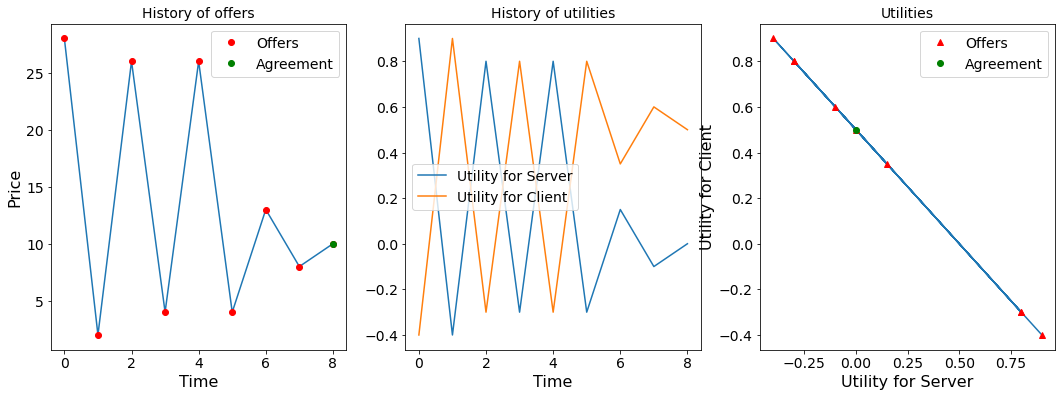

In [21]:
mins = [10,0]
maxs = [20,6]
issues = ['price']


U1 = PriceVolumeUtilityServer([10,30]) 
U2 = PriceVolumeUtilityClient([0,20])

A1 = FaratinNegotiator_AverageAbsoluteTitForTat_Server(0,max_time=10, mins=10, maxs=30, Delta = 2, k=0.1, ufun=U1, name="Server")
A2 = FaratinNegotiator_AverageAbsoluteTitForTat_Client(1,max_time=10, mins=0, maxs=20, Delta = 2, k=0.1, ufun=U2, name="Client" )


m = RubinsteinMechanism(show=True)

m.add(A1)
m.add(A2)


result = m.run()
print(f"Agreed to: {result.agreement} in {m.current_step} steps")

m.plot()

In [22]:
class FaratinNegotiator_RandomAbsoluteTitForTat_Server(FaratinNegotiator):
    
    def __init__(self, index, max_time, mins, maxs, Delta, k, s, *args, **kwargs):
        super().__init__(index, max_time, mins, maxs, None, k,*args, **kwargs)
        self.delta = Delta
        self.s = s
        self.initial = int(self.min_values + (1-self.k)*(self.max_values - self.min_values))
    
    def propose_for_self(self, ufuns: List[UtilityFunction],offer, time: int)-> int:
        if  time == 0 :
            self.last_score = ufuns[self.index](self.initial)
            self.last_offer.append(self.initial)
            return self.initial
        if time<=2*self.delta:
            if self.index == 0:
                return self.initial - 2
            return self.initial + 2
        else:
            s = self.s 
            M = 2
            x = min(max(self.last_offer[-2]+self.last_offer[(time-1)-2*self.delta]-self.last_offer[(time-1)-2*self.delta+2] + pow(-1,s)* rnd.randint(0,M),self.min_values),self.max_values)
            return x
        

In [23]:
class FaratinNegotiator_RandomAbsoluteTitForTat_Client(FaratinNegotiator):
    
    def __init__(self, index, max_time, mins, maxs, Delta, k, s, *args, **kwargs):
        super().__init__(index, max_time, mins, maxs, None, k,*args, **kwargs)
        self.delta = Delta
        self.s = s
        self.initial = int(self.min_values + (self.k)*(self.max_values - self.min_values))
    
    def propose_for_self(self, ufuns: List[UtilityFunction],offer, time: int)-> int:
        if  time == 0 :
            self.last_score = ufuns[self.index](self.initial)
            self.last_offer.append(self.initial)
            return self.initial
        if time<=2*self.delta:
            if self.index == 0:
                return self.initial - 2
            return self.initial + 2
        else:
            s = self.s 
            M = 2
            x = min(max(self.last_offer[-2]+self.last_offer[(time-1)-2*self.delta]-self.last_offer[(time-1)-2*self.delta+2] + pow(-1,s)* rnd.randint(0,M),self.min_values),self.max_values)
            return x
        

Time 0: Agent Client offers Agent Server: 2
Time 1: Agent Server is evaluating offer
Time 1: and Agent Server counteroffers: 26
Time 2: Agent Client is evaluating offer:
Time 2: and Agent Client counteroffers: 4
Time 3: Agent Server is evaluating offer
Time 3: and Agent Server counteroffers: 22
Time 4: Agent Client is evaluating offer:
Time 4: and Agent Client counteroffers: 10
Time 5: Agent Server is evaluating offer
Time 5: and Agent Server counteroffers: 15
Time 6: Agent Client is evaluating offer:
Time 6: and Agent Client accepts offer: 15
Agreed to: 15 in 7 steps


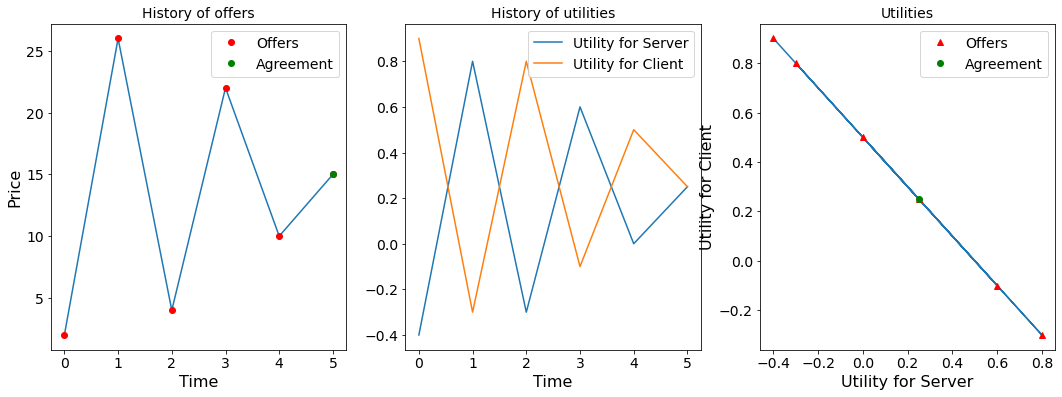

In [24]:
mins = [10,0]
maxs = [20,6]
issues = ['price']


U1 = PriceVolumeUtilityServer([10,30]) 
U2 = PriceVolumeUtilityClient([0,20])

A1 = FaratinNegotiator_RandomAbsoluteTitForTat_Server(0,max_time=10, mins=10, maxs=30, s=1, Delta = 1, k=0.1, ufun=U1, name="Server")
A2 = FaratinNegotiator_RandomAbsoluteTitForTat_Client(1,max_time=10, mins=0, maxs=20, s=0, Delta = 1, k=0.1,ufun=U2, name="Client" )


m = RubinsteinMechanism(show=True)

m.add(A1)
m.add(A2)


result = m.run()
print(f"Agreed to: {result.agreement} in {m.current_step} steps")

m.plot()

# TESTING 

In [25]:
import random 



fi = random.random()-0.1
zeta = random.randint(10,30)
zeta_s = zeta
zeta_c = zeta
min_c = 10
max_c = min_c + zeta_c
min_s = int(zeta_c*fi + min_c)
max_s = int(min_s + zeta_s)

print("Client: Min={}, Max Client={}".format(min_c,max_c))
print("Server: Min={}, Max Client={}".format(min_s,max_s))


Client: Min=10, Max Client=26
Server: Min=15, Max Client=31


In [26]:
k = 0.1

In [27]:
U1 = PriceVolumeUtilityServer([min_s,max_s]) 
U2 = PriceVolumeUtilityClient([min_c,max_c]) 


ServerAgents = []
ClientAgents = []

#TIME DEPENDENT TACTICS

#B=1 NORMAL
Ls = FaratinNegotiatorTimeServer(0,max_time=10, mins=min_s, maxs=max_s, Beta = 1, k= k, ufun=U1, name="Server-Time-Normal")
Lc = FaratinNegotiatorTimeClient(1,max_time=10, mins=min_c, maxs=max_c, Beta = 1, k= k, ufun=U2, name="Client-Time-Normal" )
ServerAgents.append(Ls)
ClientAgents.append(Lc)

#B<1 BOULWARE
Bs = FaratinNegotiatorTimeServer(0,max_time=10, mins=min_s, maxs=max_s, Beta = 1, k= k, ufun=U1, name="Server-Time-Boulware")
Bc = FaratinNegotiatorTimeClient(1,max_time=10, mins=min_c, maxs=max_c, Beta = 1, k= k, ufun=U2, name="Client-Time-Boulware" )
ServerAgents.append(Bs)
ClientAgents.append(Bc)

#B>1 CONCEDER
Cs = FaratinNegotiatorTimeServer(0,max_time=10, mins=min_s, maxs=max_s, Beta = 1, k= k, ufun=U1, name="Server-Time-Boulware")
Cc = FaratinNegotiatorTimeClient(1,max_time=10, mins=min_c, maxs=max_c, Beta = 1, k= k, ufun=U2, name="Client-Time-Boulware" )
ServerAgents.append(Cs)
ClientAgents.append(Cc)

#RESOURCES DEPENDENT TACTICS
Rs = FaratinNegotiatorResourceServer(0,max_time=10, mins=min_s, maxs=max_s, Beta = 1, k= k, ufun=U1, name="Server-Resource")
Rc = FaratinNegotiatorResourceClient(1,max_time=10, mins=min_c, maxs=max_c, Beta = 1, k= k, ufun=U2, name="Client-Resource" )
ServerAgents.append(Rs)
ClientAgents.append(Rc)

#BEHAVIOUR DEPENDENT TACTICS
REs = FaratinNegotiator_Relative_Tit_For_Tat_Server(0,max_time=10, mins=min_s, maxs=max_s, Delta = 1, k=k, ufun=U1, name="Server-Behaviour-Relative")
REc = FaratinNegotiator_Relative_Tit_For_Tat_Client(1,max_time=10, mins=min_c, maxs=max_c, Delta = 1, k=k,ufun=U2, name="Client-Behaviour-Relative" )
ServerAgents.append(REs)
ClientAgents.append(REc)

RAs = FaratinNegotiator_AverageAbsoluteTitForTat_Server(0,max_time=10, mins=min_s, maxs=max_s, Delta = 2, k=k,ufun=U1, name="Server-Bevaviour-Average")
RAc = FaratinNegotiator_AverageAbsoluteTitForTat_Client(1,max_time=10, mins=min_c, maxs=max_c, Delta = 2, k=k,ufun=U2, name="Client-Behaviour-Average" )
ServerAgents.append(RAs)
ClientAgents.append(RAc)

AVs = FaratinNegotiator_RandomAbsoluteTitForTat_Server(0,max_time=10, mins=min_s, maxs=max_s, s=1, Delta = 1, k=k, ufun=U1, name="Server-Bevaviour-Random")
AVc = FaratinNegotiator_RandomAbsoluteTitForTat_Client(1,max_time=10, mins=min_c, maxs=max_c, s=0, Delta = 1, k=k,ufun=U2, name="Client-Bevaiour-Random" )
ServerAgents.append(AVs)
ClientAgents.append(AVc)



# WORLD SIMULATION

In [31]:
import random

fi = 0#random.random()-0.1
zeta = random.randint(10,30)
zeta_s = zeta
zeta_c = zeta
min_c = 10
max_c = min_c + zeta_c
min_s = int(zeta_c*fi + min_c)
max_s = int(min_s + zeta_s)

print(min_c,max_c)
print(min_s,max_s)

10 37
10 37


In [28]:
class FaratinAgentServer():
    
    def __init__(self, negotiator_type, mins, maxs, U,*args,**kwargs):
        self._negotiator = negotiator_type
        self.mins = mins
        self.maxs = maxs
        self.U = U
    
    def negotiator(self):
        if self._negotiator == 'Ls':
            return FaratinNegotiatorTimeServer(0,max_time=20, mins=self.mins, maxs=self.maxs, Beta = 1, k= k, ufun=self.U, name="Server-Time-Normal")
        if self._negotiator == 'Bs':
            return  FaratinNegotiatorTimeServer(0,max_time=20, mins=self.mins, maxs=self.maxs, Beta = 0.1, k= k, ufun=self.U, name="Server-Time-Boulware")
        if self._negotiator == 'Cs':
            return FaratinNegotiatorTimeServer(0,max_time=20, mins=self.mins, maxs=self.maxs, Beta = 10, k= k, ufun=self.U, name="Server-Time-Boulware") 
        if self._negotiator == 'Rs':
            return FaratinNegotiatorResourceServer(0,max_time=20, mins=self.mins, maxs=self.maxs, Beta = 1, k= k, ufun=self.U, name="Server-Resource")
        if self._negotiator == 'REs':
            return FaratinNegotiator_Relative_Tit_For_Tat_Server(0,max_time=20, mins=self.mins, maxs=self.maxs, Delta = 1,k=k, ufun=self.U, name="Server-Behaviour-Relative")
        if self._negotiator == 'RAs':
            return FaratinNegotiator_AverageAbsoluteTitForTat_Server(0,max_time=20, mins=self.mins, maxs=self.maxs, Delta = 2, k=k, ufun=self.U, name="Server-Bevaviour-Average")
        if self._negotiator == 'Avs':
            return FaratinNegotiator_RandomAbsoluteTitForTat_Server(0,max_time=20, mins=self.mins, maxs=self.maxs, s=1, Delta = 1, k=k,ufun=self.U, name="Server-Bevaviour-Random")
        

In [29]:
class FaratinAgentClient():
    def __init__(self, negotiator_type, mins, maxs, U,*args ,**kwargs):
        self._negotiator = negotiator_type
        self.mins = mins
        self.maxs = maxs
        self.U = U
    
    def negotiator(self):
        if self._negotiator == 'Lc':
            return FaratinNegotiatorTimeClient(1,max_time=20, mins=self.mins, maxs=self.maxs, Beta = 1, k= k, ufun=self.U, name="Client-Time-Normal" )
        if self._negotiator == 'Bc':
            return FaratinNegotiatorTimeClient(1,max_time=20, mins=self.mins, maxs=self.maxs, Beta = 0.1, k= k,  ufun=self.U, name="Client-Time-Boulware" )
        if self._negotiator == 'Cc':
            return FaratinNegotiatorTimeClient(1,max_time=20, mins=self.mins, maxs=self.maxs, Beta = 10, k= k, ufun=self.U, name="Client-Time-Boulware" )
        if self._negotiator == 'Rc':
            return FaratinNegotiatorResourceClient(1,max_time=20, mins=self.mins, maxs=self.maxs, Beta = 1, k= k, ufun=self.U, name="Client-Resource" )
        if self._negotiator == 'REc':
            return FaratinNegotiator_Relative_Tit_For_Tat_Client(1,max_time=20, mins=self.mins, maxs=self.maxs, Delta = 1, k=k, ufun=self.U, name="Client-Behaviour-Relative" )
        if self._negotiator == 'RAc':
            return FaratinNegotiator_AverageAbsoluteTitForTat_Client(1,max_time=20, mins=self.mins, maxs=self.maxs, Delta = 2, k=k, ufun=self.U, name="Client-Behaviour-Average" )
        if self._negotiator == 'Avc':
            return FaratinNegotiator_RandomAbsoluteTitForTat_Client(1,max_time=20, mins=self.mins, maxs=self.maxs, s=0, Delta = 1, k=k, ufun=self.U, name="Client-Bevaiour-Random" )




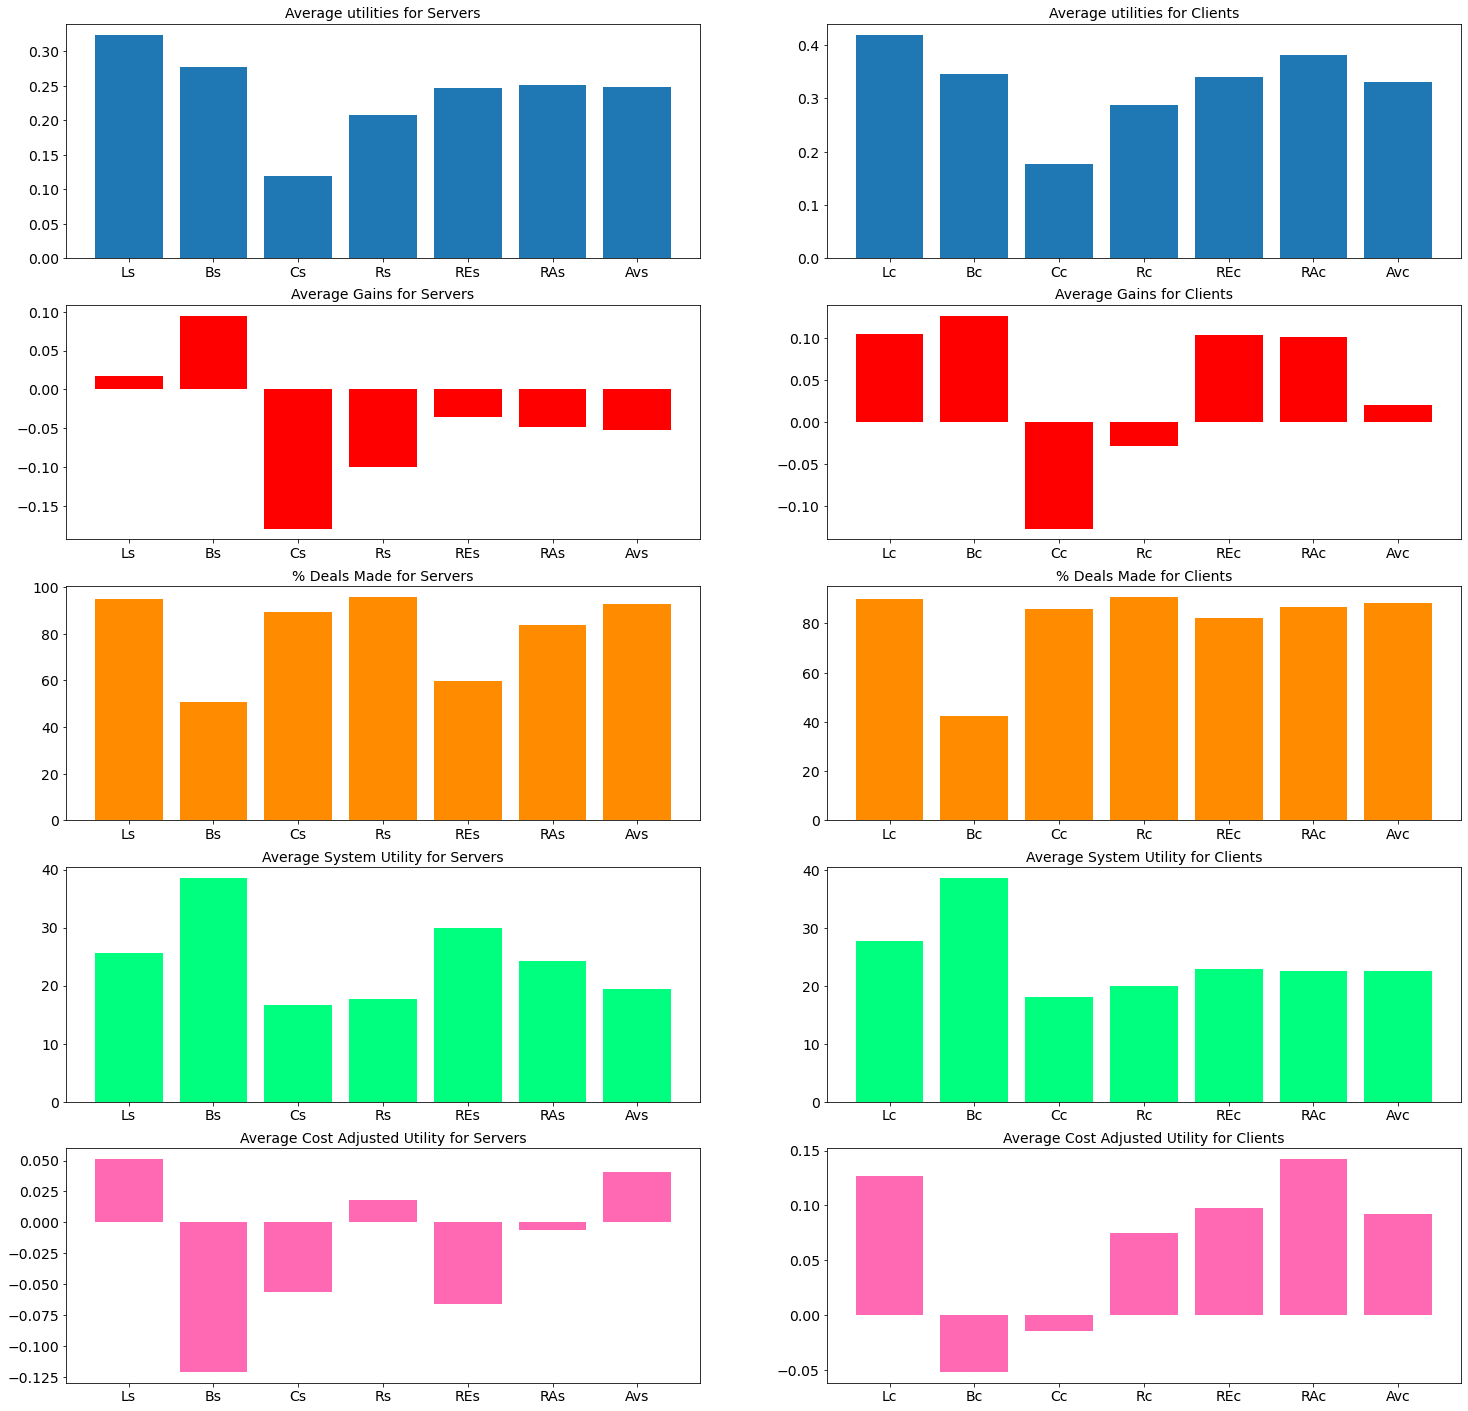

In [41]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


def Simulation(n_sims):
    outcomes_col = []
    intrinsic_u_col = []
    gains_col = []
    cost_col=[]
    ServerAgents_types = ['Ls','Bs','Cs','Rs','REs','RAs','Avs']
    ClientAgents_types = ['Lc','Bc','Cc','Rc','REc','RAc','Avc']
    
    tau = 0.022
    Matrix_outcomes = np.empty((7,7,n_sims),dtype=object)
    Matrix_utilities = np.empty((7,7,n_sims),dtype=object)
    Matrix_costs = np.zeros((7,7,n_sims))
    Matrix_costs2 = np.zeros((7,7,n_sims))
    Matrix_gains = np.empty((7,7,n_sims),dtype=object)

    for n in range(n_sims):
        
        fi = random.random()-0.1
        #f1 = 0
        zeta = random.randint(10,30)
        zeta_s = zeta
        zeta_c = zeta
        min_c = 10
        max_c = min_c + zeta_c
        min_s = int(zeta_c*fi + min_c)
        max_s = int(min_s + zeta_s)
        efficient_outcome = (max_c + min_s)/2 
        
        U1 = PriceVolumeUtilityServer([min_s,max_s]) 
        U2 = PriceVolumeUtilityClient([min_c,max_c]) 
        
        for i,server_type in enumerate(ServerAgents_types):
            for j,client_type in enumerate(ClientAgents_types):
                m = RubinsteinMechanism(show=False)
                m.add(FaratinAgentServer(negotiator_type = server_type, mins=min_s,maxs=max_s, U=U1).negotiator())
                m.add(FaratinAgentClient(negotiator_type = client_type, mins=min_c,maxs=max_c, U=U2).negotiator())
                result = m.run()
                Matrix_utilities[i][j][n] = (U1(result.agreement),U2(result.agreement)) if result.agreement != None else (0,0)
                Matrix_gains[i][j][n] = (U1(result.agreement)-U1(efficient_outcome),U2(result.agreement)-U2(efficient_outcome)) if result.agreement != None else (0,0)
                Matrix_outcomes[i][j][n] = result.agreement
                Matrix_costs[i][j][n] = m.current_step*2
                Matrix_costs2[i][j][n] = math.tanh(m.current_step*tau)

                
    Utilities = np.empty((7,7),dtype=object)
    Gains = np.empty((7,7),dtype=object)
    Costs = np.empty((7,7),dtype=object)
    Costs2 = np.empty((7,7),dtype=object)
    Outcomes = np.empty((7,7),dtype=object)

    for i in range(7):
        for j in range(7):
            Utilities[i][j] = (sum(m[0] for m in Matrix_utilities[i][j])/n_sims,sum(m[1] for m in Matrix_utilities[i][j])/n_sims)
            Gains[i][j] = (sum(m[0] for m in Matrix_gains[i][j])/n_sims,sum(m[1] for m in Matrix_gains[i][j])/n_sims)
            Costs[i][j] = sum(c for c in Matrix_costs[i][j])/n_sims
            Costs2[i][j] = sum(c for c in Matrix_costs2[i][j])/n_sims
            #Outcomes[i][j] = sum(o for o in Matrix_outcomes[i][j] if o != None)/n_sims
            Outcomes[i][j] = sum(1 for c in Matrix_outcomes[i][j] if c!=None)/n_sims*100


    #Utilities
    Utilities_ = pd.DataFrame(Utilities)
    Utilities_servers_ = Utilities_.sum(axis=1)
    Utilities_servers = [Utilities_servers_[j][i] for j in range(len(Utilities_servers_)) for i in range(len(Utilities_servers_[0])) if i%2 == 0]
    Servers_utilities = [sum(Utilities_servers[x:x+7])/7 for x in range(0, len(Utilities_servers),7)]
    Utilities_clients_ = Utilities_.sum(axis=0)
    Utilities_clients = [Utilities_clients_[j][i] for j in range(len(Utilities_clients_)) for i in range(len(Utilities_clients_[0])) if i%2 == 1]
    Clients_utilities = [sum(Utilities_clients[x:x+7])/7 for x in range(0, len(Utilities_clients),7)]
    
    #Gains 
    Gains_ = pd.DataFrame(Gains)
    Gains_servers_ = Gains_.sum(axis=1)
    Gains_servers = [Gains_servers_[j][i] for j in range(len(Gains_servers_)) for i in range(len(Gains_servers_[0])) if i%2 == 0]
    Servers_Gains = [sum(Gains_servers[x:x+7])/7 for x in range(0, len(Gains_servers),7)]
    Gains_clients_ = Gains_.sum(axis=0)
    Gains_clients = [Gains_clients_[j][i] for j in range(len(Gains_clients_)) for i in range(len(Gains_clients_[0])) if i%2 == 1]
    Clients_Gains = [sum(Gains_clients[x:x+7])/7 for x in range(0, len(Gains_clients),7)]
    

    #% Deals Made    
    pctg_deals_servers =  sum([Outcomes[i][:] for i in range(7)])/7
    pctg_deals_clients =  sum([Outcomes.T[j][:] for j in range(7)])/7
                            

    #Costs 
    avg_cost_servers =  sum([Costs[i][:] for i in range(7)])/7
    avg_cost_clients =  sum([Costs.T[j][:] for j in range(7)])/7
    
    avg_cost_servers2 =  sum([np.array(Servers_utilities) - np.array(Costs2[i][:]) for i in range(7)])/7
    avg_cost_clients2 =  sum([np.array(Clients_utilities) - np.array(Costs2.T[j][:]) for j in range(7)])/7
    

    fig, (ax1,ax2,ax3,ax4,ax5) =  plt.subplots(5,2,figsize=(25,25))
    ax1[0].bar(ServerAgents_types,Servers_utilities)
    ax1[0].set_title("Average utilities for Servers")
    ax1[1].bar(ClientAgents_types,Clients_utilities)
    ax1[1].set_title("Average utilities for Clients")
    
    ax2[0].bar(ServerAgents_types,Servers_Gains,color='red')
    ax2[0].set_title("Average Gains for Servers")
    ax2[1].bar(ClientAgents_types,Clients_Gains,color='red')
    ax2[1].set_title("Average Gains for Clients")
    
    ax3[0].bar(ServerAgents_types,pctg_deals_servers,color='darkorange')
    ax3[0].set_title("% Deals Made for Servers")
    ax3[1].bar(ClientAgents_types,pctg_deals_clients,color='darkorange')
    ax3[1].set_title("% Deals Made for Clients")
    
    ax4[0].bar(ServerAgents_types,avg_cost_servers,color='springgreen')
    ax4[0].set_title("Average System Utility for Servers")
    ax4[1].bar(ClientAgents_types,avg_cost_clients,color='springgreen')
    ax4[1].set_title("Average System Utility for Clients")
    

    ax5[0].bar(ServerAgents_types,avg_cost_servers2,color='hotpink')
    ax5[0].set_title("Average Cost Adjusted Utility for Servers")
    ax5[1].bar(ClientAgents_types,avg_cost_clients2,color='hotpink')
    ax5[1].set_title("Average Cost Adjusted Utility for Clients")
    
    
    
Simulation(200)